# Evaluating the models

## import required packages

In [1]:
import pickle
import math
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

### define experiment and model names <a name="introduction"></a>

In [4]:
ALL_EXPERIMENTS = ['memory', 'memory2', 'memory_color_short', 'memory_color_long']
ALL_MODELS = ['var_beta', 'invar_beta']

## example: one dataset, one model

### choose dataset and model

In [5]:
exp_name = ALL_EXPERIMENTS[0]
model_name = ALL_MODELS[0]

### load model and fit

In [6]:
def load_model_fit(model_name, exp_name):
    """
    load dictionary containing the model's stan code (model) and sampling results (fit)
    """
    with open(f'output/model_fit/model_fit_{model_name}_{exp_name}.pkl', 'rb') as f:
        model_fit = pickle.load(f)
    model = model_fit['model']
    fit = model_fit['fit']
    return model, fit

In [ ]:
model, fit = load_model_fit(model_name, exp_name)

### get goodness-of-fit metrics for the model

In [41]:
def get_model_metric(fit, metric_name):
    """
    compute goodness-of-fit metrics for the model, e.g., WAIC
    """
    if metric_name.lower() == 'waic':
        metric = az.waic(fit)
    else:
        metric = az.loo(fit)
        
    metric.to_csv(f'output/metrics/{metric_name}/{metric_name}_{model_name}_{exp_name}.csv')

    return metric

In [39]:
waic = get_model_metric(fit, 'waic')

/home/adkinsty/miniconda3/envs/cocoa/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


### get group-level parameters of interest

In [25]:
def inv_logit(p):
    """
    calculates the inverse logit of p
    """
    return math.exp(p) / (1 + math.exp(p))

inv_logit_vec = np.vectorize(inv_logit)


def linear_fn(b, m=0, x=0):
    """
    add linear effet m of a covariate x on an intercept b for a parameter
    transform result to constrained [0,1] space using inverse logit
    """
    return inv_logit(b + m * x)

def dif(a, b):
    """
    subtract b from a
    """
    return a - b

def get_group_par(fit, model_name, exp_name):
    """
    gather group level parameters
    compute effects of condition (post_err vs post_cor) on these parameters
    """
    group_par = {}
    for key, value in fit.items():
        if 'loc' in key:
            group_par[key] = value[0] 
    group_par = pd.DataFrame(group_par)
    
    group_par['delta_alpha_loc'] = 0
    if model_name == 'invar_beta':
        group_par['delta_beta_loc'] = 0
        
    covar = .5
    group_par['mu_post_err'] = group_par.apply(lambda x: linear_fn(x.mu_loc, x.delta_mu_loc, covar), axis=1)
    group_par['sigma_post_err'] = group_par.apply(lambda x: linear_fn(x.sigma_loc, x.delta_sigma_loc, covar), axis=1)
    group_par['beta_post_err'] = group_par.apply(lambda x: linear_fn(x.beta_loc, x.delta_beta_loc, covar), axis=1)
    group_par['alpha_post_err'] = group_par.apply(lambda x: linear_fn(x.alpha_loc, x.delta_alpha_loc, covar), axis=1)

    covar = -.5
    group_par['mu_post_cor'] = group_par.apply(lambda x: linear_fn(x.mu_loc, x.delta_mu_loc, covar), axis=1)
    group_par['sigma_post_cor'] = group_par.apply(lambda x: linear_fn(x.sigma_loc, x.delta_sigma_loc, covar), axis=1)
    group_par['beta_post_cor'] = group_par.apply(lambda x: linear_fn(x.beta_loc, x.delta_beta_loc, covar), axis=1)
    group_par['alpha_post_cor'] = group_par.apply(lambda x: linear_fn(x.alpha_loc, x.delta_alpha_loc, covar), axis=1)

    group_par['mu_diff'] = group_par.apply(lambda x: dif(x.mu_post_err, x.mu_post_cor), axis=1)
    group_par['sigma_diff'] = group_par.apply(lambda x: dif(x.sigma_post_err, x.sigma_post_cor), axis=1)
    group_par['beta_diff'] = group_par.apply(lambda x: dif(x.beta_post_err, x.beta_post_cor), axis=1)

    group_par.to_csv(f'output/group_par/dat/group_par_{model_name}_{exp_name}.csv', index=False)
    group_par.head()
    
    return group_par

In [ ]:
group_par = get_group_par(fit, model_name, exp_name)

### visualize posteriors for group-level parameters

In [45]:
def plot_group_par(group_par, model_name, exp_name):
    """
    plot posteriors for group-level effects of condition (post_err vs post_cor) on the parameters
    """
    if model_name == 'var_beta':
        pars = ['mu', 'sigma', 'beta']
    else:
        pars = ['mu', 'sigma']
    diff_par = [f'{par}_diff' for par in pars]
    for par_name in diff_par:
        plt.hist(group_par[par_name])
        plt.xlim((-.1, .1))
        plt.ylim((0, 4000))
        plt.xlabel(par_name)
        path_to_fig = f'output/group_par/fig/{par_name}_{model_name}_{exp_name}.png'
        plt.savefig(path_to_fig)
        plt.show()
    return f'Figures saved to {path_to_fig}'

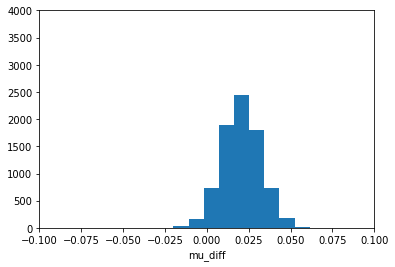

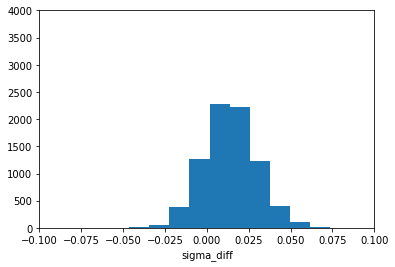

'Figures saved to output/group_par/fig/sigma_diff_invar_beta_memory_color_long.png'

In [46]:
plot_group_par(group_par, model_name, exp_name)

### get predicted conditional accuracy for group-level parameters

In [36]:
def rpm(time, mu, sigma, beta, alpha):
    """
    calculates probability of correct response at a given time (theta)
    duration required to ready a response is normal(mu, sigma)
    probability of correct response before ready is alpha
    probability of correct response after ready is beta
    """
    p_ready = norm.cdf(time, mu, sigma)
    p_not_ready = 1 - p_ready
    p_acc = (p_ready * beta) + (p_not_ready * alpha)
    return p_acc

def get_group_pred(group_par, model_name, exp_name):
    """
    use group level parameters to computue posterior response accuracy by condition and time
    """
    group_theta = []
    times = []
    samples = []
    conditions = []

    num_samples = group_par.shape[0]
    num_timepoints = 10

    for condition in ['post_err', 'post_cor']:

        print(f'Condition is {condition}')

        for i in tqdm(range(0, num_samples)):

            mu    = group_par.loc[i, f'mu_{condition}']
            sigma = group_par.loc[i, f'sigma_{condition}']
            beta  = group_par.loc[i, f'beta_{condition}']
            alpha = group_par.loc[i, f'alpha_{condition}']

            for t in range(0, num_timepoints):

                time = t / num_timepoints
                group_theta += [rpm(time, mu, sigma, beta, alpha)]
                times += [time]
                samples += [i]
                conditions += [condition]

    pred = pd.DataFrame({'time':times, 'condition':conditions, 'sample':samples, 'pred_acc':group_theta})
    pred.to_csv(f'output/group_pred/dat/pred_{model_name}_{exp_name}.csv', index=False)
    pred.head()
    return pred

In [ ]:
pred = get_group_pred(group_par, model_name, exp_name)

### get credible intervals for predicted conditional accuracy

In [28]:
def get_ci_pred(pred, model_name, exp_name, width=.95):
    """
    compute mean and credible interval for posterior conditional response accuracies
    """
    ub = .5 + (width/2)
    lb = .5 - (width/2)
    mean_pred = pred.groupby(['time', 'condition'])['pred_acc'].mean().to_frame().reset_index().rename(columns={'pred_acc':'mean_acc'})
    ub_pred = pred.groupby(['time', 'condition'])['pred_acc'].apply(lambda x: np.quantile(x, ub)).to_frame().reset_index().rename(columns={'pred_acc':'ub_acc'})
    lb_pred = pred.groupby(['time', 'condition'])['pred_acc'].apply(lambda x: np.quantile(x, lb)).to_frame().reset_index().rename(columns={'pred_acc':'lb_acc'})
    ci_pred = pd.merge(lb_pred, ub_pred, on=['time', 'condition'], how='left')
    ci_pred = pd.merge(ci_pred, mean_pred, on=['time', 'condition'], how='left')
    ci_pred.to_csv(f'output/group_pred/dat/ci_pred_{model_name}_{exp_name}.csv', index=False)
    ci_pred.head()
    return ci_pred

In [ ]:
ci_pred = get_ci_pred(pred, model_name, exp_name, width=.95)

### plot credible intervals for predicted conditional accuracy

In [29]:
def plot_ci_pred(ci_pred, model_name, exp_name):
    """
    plot mean and credible interval for posterior conditional response accuracies
    """
    post_err_pred = ci_pred[ci_pred.condition == 'post_err']
    post_cor_pred = ci_pred[ci_pred.condition  == 'post_cor']
    plt.plot(post_err_pred.time, post_err_pred.mean_acc, 'b-', label='post error')
    plt.fill_between(post_err_pred.time, post_err_pred.lb_acc, post_err_pred.ub_acc, color='b', alpha=0.2)
    plt.plot(post_cor_pred.time, post_cor_pred.mean_acc, 'r-', label='post correct')
    plt.fill_between(post_cor_pred.time, post_cor_pred.lb_acc, post_cor_pred.ub_acc, color='r', alpha=0.2)
    plt.legend()
    path_to_fig = f'output/group_pred/fig/ci_pred_{model_name}_{exp_name}.png'
    plt.savefig(path_to_fig)
    plt.show()
    return f'Saved figure to {path_to_fig}'

In [ ]:
plot_ci_pred(ci_pred, model_name, exp_name)

## end-to-end loop: all models and experiments



Experiment: memory
Model: var_beta

Loading model...
Getting group parameters...


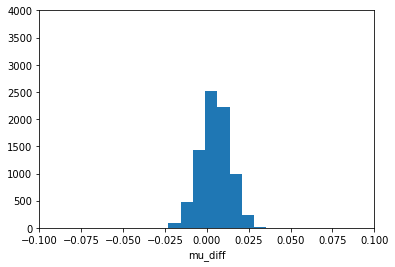

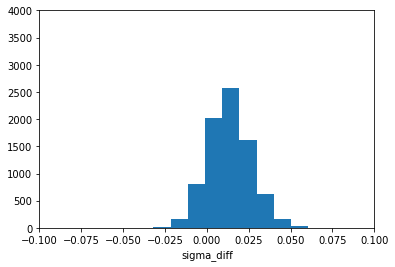

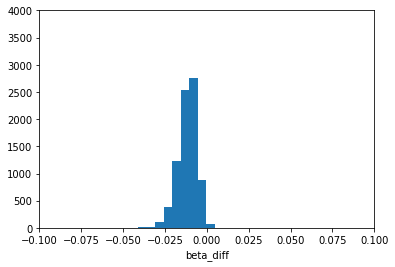



Experiment: memory
Model: invar_beta

Loading model...
Getting group parameters...


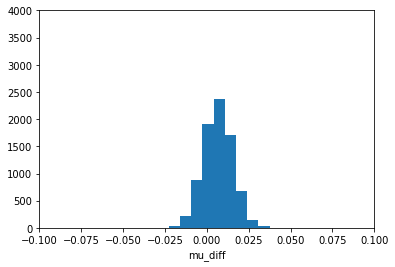

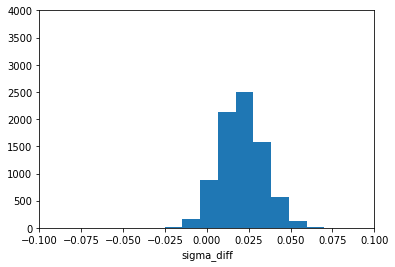



Experiment: memory2
Model: var_beta

Loading model...
Getting group parameters...


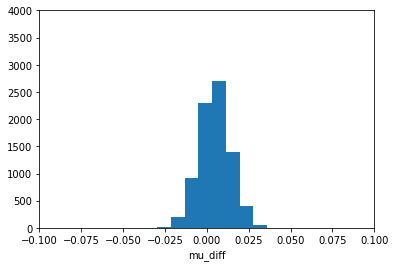

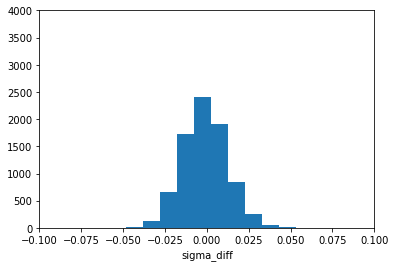

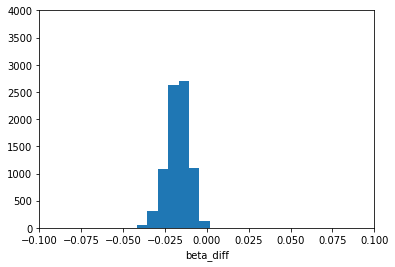



Experiment: memory2
Model: invar_beta

Loading model...
Getting group parameters...


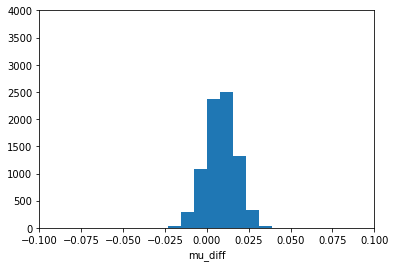

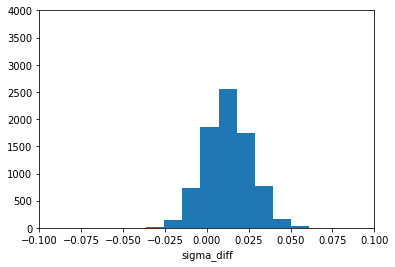



Experiment: memory_color_short
Model: var_beta

Loading model...
Getting group parameters...


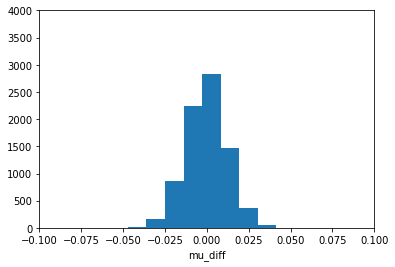

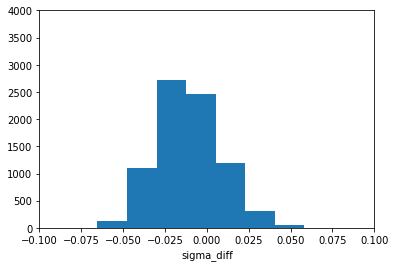

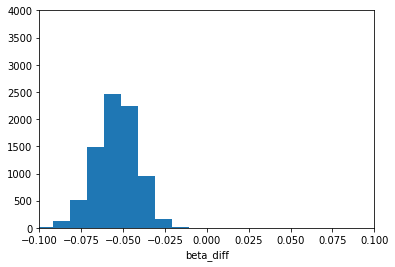



Experiment: memory_color_short
Model: invar_beta

Loading model...
Getting group parameters...


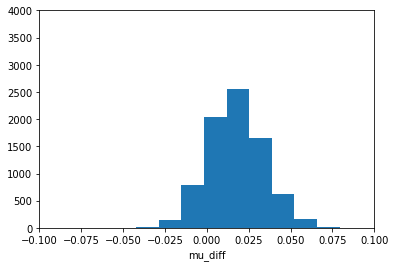

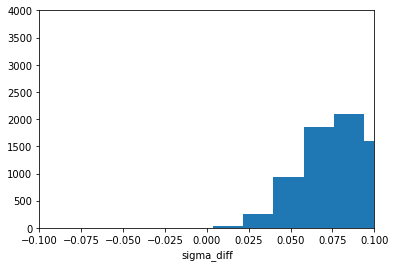



Experiment: memory_color_long
Model: var_beta

Loading model...
Getting group parameters...


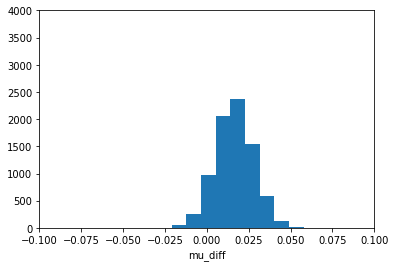

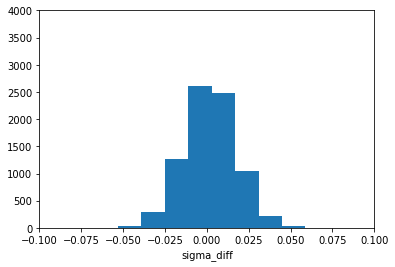

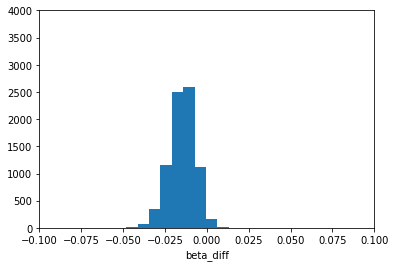



Experiment: memory_color_long
Model: invar_beta

Loading model...
Getting group parameters...


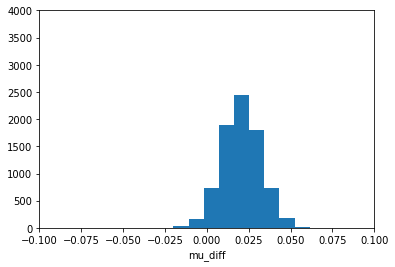

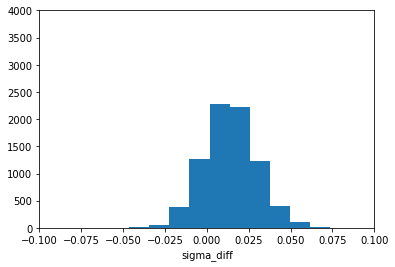

In [47]:
for exp_name in ALL_EXPERIMENTS:
    for model_name in ALL_MODELS:
        
        print(f'\n\nExperiment: {exp_name}')
        print(f'Model: {model_name}\n')
        
        print("Loading model...")
        model, fit = load_model_fit(model_name, exp_name)
        # print("Getting metrics...")
        # metric = get_model_metric(fit, 'loo')
        print("Getting group parameters...")
        group_par = get_group_par(fit, model_name, exp_name)
        plot_group_par(group_par, model_name, exp_name)
        print("Getting group predictions...")
        pred = get_group_pred(group_par, model_name, exp_name)
        ci_pred = get_ci_pred(pred, model_name, exp_name, width=.95)
        plot_ci_pred(ci_pred, model_name, exp_name)

# Simple model comparison

In [7]:
for exp_name in ALL_EXPERIMENTS:
    print(f'Comparing models for \"{exp_name}\" experiment...')
    model1, fit1 = load_model_fit('var_beta', exp_name)
    model2, fit2 = load_model_fit('invar_beta', exp_name)
    model_comparison = az.compare({'var_beta':fit1, 'invar_beta':fit2})
    model_comparison.to_csv(f'output/metrics/compare_{exp_name}.csv', index=False)

Comparing models for "memory" experiment...
Comparing models for "memory2" experiment...


/home/adkinsty/miniconda3/envs/cocoa/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/adkinsty/miniconda3/envs/cocoa/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Comparing models for "memory_color_short" experiment...
Comparing models for "memory_color_long" experiment...
